# Notebook that computes Shapiro delay from galaxy cluster catalogs

Written for Python2 (2.7.12)

Authors: Olivier Minazzoli

Date (yymmdd): 190722

This code generates the plots in FIG. 3 of the manuscript LIGO-P1900149

Details of the computation in Shapiro_main_code_TABLE1_FIG2.ipynb

Code tested with matplotlib 2.1.2, 2.2.3 and 2.2.4. Plotting issues were found with version 1.5.1.

In [1]:
# Import scientific package numpy
import numpy as np
#Import I/O packages
from io import BytesIO
# Import package to deal with astronomical coordinates
from astropy import units as u
from astropy.coordinates import SkyCoord
# Import plotting package
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Import constants from LAL 
from lal import PC_SI, C_SI, G_SI, MSUN_SI

In [3]:
# Read the file where the data file names are stored
file_names = np.genfromtxt('file_names.in', dtype='string', comments = '#')

In [4]:
# Define name of file to be called
catalog = file_names[3]   # must be in 'catalogs_data/%s.dat' 

# Read the file where the characteristics of the gravitational sources of the catalog are given: ra, dec, distance (Mpc), Mass

cata = np.genfromtxt('catalogs_data/%s.out' % catalog, comments ='#')

Nbr_sources = cata.shape[0]     # Number of sources in the catalog

# Rewrite file without rows with null mass (happends (e.g.) when not enough objects to infer mass from Virial theorem)
cata_wo0 = np.empty([0,4])      # set new array of data
for i in range(Nbr_sources):
    if cata[i , 3] != 0:
        cata_wo0 = np.insert(cata_wo0, 0, cata[i], axis = 0)

Nbr_sources_wo0 = cata_wo0.shape[0]     # Number of sources in the catalog without zero mass

# Set vectors for computation
cataRA = cata_wo0[:, 0]             # Vector with all RA coordinates from catalog
cataDEC = cata_wo0[:, 1]            # Vector with all DEC coordinates from catalog
cataDIS = cata_wo0[:, 2]            # Vector with all distances from catalog
cataMASS = cata_wo0[:, 3]           # Vector with all masses from catalog

In [5]:
# Create RA and DEC vectors corresponding to sources uniformly distributed in the sky

interval = 1.         # Interval defining the resolution (1 => super high resolution)
#interval = 2.         # Interval defining the resolution (2 => high resolution)
#interval = 5.         # Interval defining the resolution (5 => good enough resolution)
#interval = 10.         # Interval defining the resolution (10 => bad reslution)
sourceRA = np.arange(0,360,interval)
sourceDEC = np.arange(-90,90,interval/2.)
if len(sourceDEC) != len(sourceRA):
    print 'Warning: array size incompatible between RA and DEC'

# Set array of positions in the sky
array_B = np.empty([0,2]) 
for i in range(int(360/interval)):
    for j in range(int(180/interval)):
        array_B = np.insert(array_B, 0, [i*interval, j*interval-90], axis = 0)

## Skymap at 26 Mpc

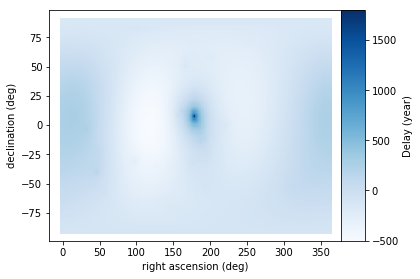

In [6]:
d_L = 26.

dt_Shapiro_mean = np.empty([0,2]) 


# Set array of vector pointing toward the source of the waves,
vec_B = SkyCoord(ra = array_B[:,0]*u.degree, dec = array_B[:,1]*u.degree, distance = d_L*u.mpc)
size_vec_B = len(vec_B)
# Set array of vector pointing toward each cluster
vec = SkyCoord(ra=cataRA*u.degree, dec=cataDEC*u.degree, distance=cataDIS*u.mpc) # Coordinate array
#######
dt_Shapiro = np.empty([0,3]) 
for i in range(size_vec_B):
    theta_A = vec_B[i].separation(vec).rad # angle between source and line of sight
    r_B = vec_B[i].separation_3d(vec).mpc
    #cata_shapiro = np.c_[cataRA, cataDEC, cataDIS, cataMASS * np.log((cataDIS + r_B + d_L)/(cataDIS + r_B - d_L))*2.*G_SI / C_SI**3 * MSUN_SI/(3600.*24.*365.)] # wrong equation found in literature
    cata_shapiro = np.c_[cataRA, cataDEC, cataDIS, cataMASS * (np.log((cataDIS + r_B + d_L)/(cataDIS + r_B - d_L))-d_L/ cataDIS - 0.5 * (d_L/ cataDIS)**2. * np.cos(theta_A))*2.*G_SI / C_SI**3 * MSUN_SI/(3600.*24.*365.), cataMASS] # Equation with appropriate gauge
    dt_Shapiro = np.insert(dt_Shapiro, 0, [vec_B[i].ra.degree,vec_B[i].dec.degree,np.sum(cata_shapiro[:,3])], axis = 0)
######
    
dt_Shapiro_mean = np.insert(dt_Shapiro_mean, 0, [d_L, np.mean(dt_Shapiro[:,2])], axis = 0) # keep track of the evolution of the mean Shapiro value at each d_L
    
plt.scatter(dt_Shapiro[:,0],dt_Shapiro[:,1], c = dt_Shapiro[:,2], marker = 's', cmap = 'Blues')
#plt.title('From %s (Mean delay = %.0e years) at %.0f Mpc' % (catalog,dt_Shapiro_mean[0,1],d_L), loc ='center')
plt.xlabel('right ascension (deg)')
plt.ylabel('declination (deg)')
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
#cax = plt.axes([0.8, 0.1, 0.025, 0.8])
#plt.colorbar(cax=cax)#.set_label('Delay (yr) from each point of a sphere at %.0f Mpc' % d_L)
cax = plt.axes([0.8, 0.1, 0.055, 0.8])
plt.colorbar(cax=cax).set_label('Delay (year)')
plt.savefig('Sphere_outputs/OverviewSky_%s|%sMpc.png' % (catalog,d_L), dpi= 200, bbox_inches="tight")
#plt.clf() # clear figure